In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Lasso

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.nn import sigmoid

In [2]:
# from jax.config import config; config.update("jax_enable_x64", True)

In [3]:
EPS = 1e-10
fontsize=13

# Testing

In [4]:
import sys
sys.path.append('../')
import adaprobe

In [7]:
N = 20
K = 1000
powers = np.arange(20, 51, 10)
phi_1 = np.random.uniform(2.5, 5.5, N)
a = 0.2
sigma = 1

sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)

In [8]:
num_targets = 4

In [9]:
# sim.simulate(trials=K, powers=powers)
sim.simulate_multistim(trials=K, num_targets=num_targets, powers=powers)

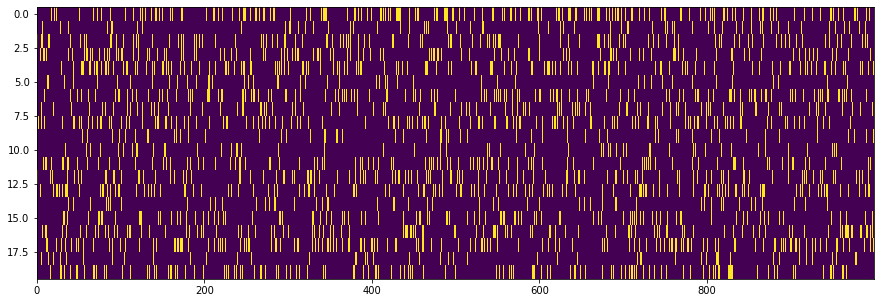

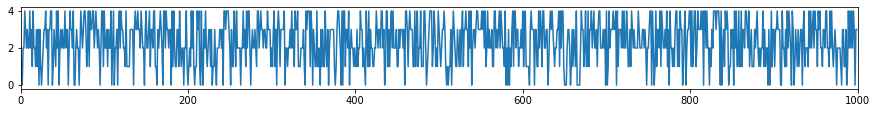

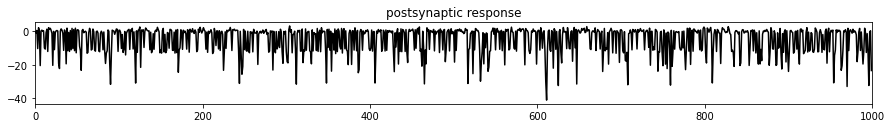

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(sim.spks, aspect='auto', interpolation='nearest')
plt.show()

plt.figure(figsize=(15, 1.5))
plt.plot(np.sum(sim.spks, 0))
plt.xlim([0, K])
plt.show()

plt.figure(figsize=(15, 1.5))
plt.title('postsynaptic response')
plt.plot(sim.y, color='k')
plt.xlim([0, K])
plt.show()

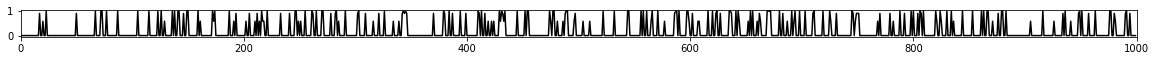

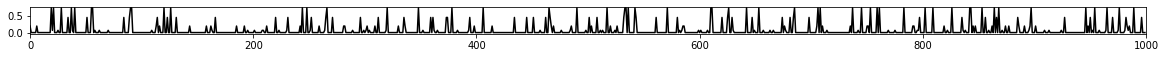

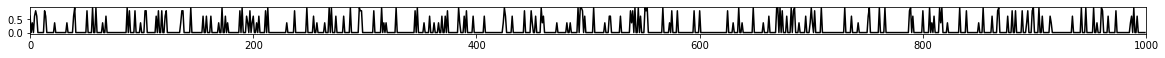

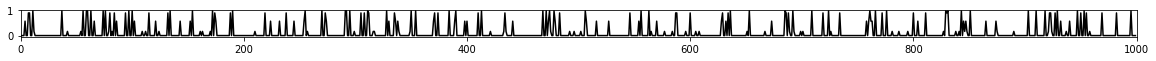

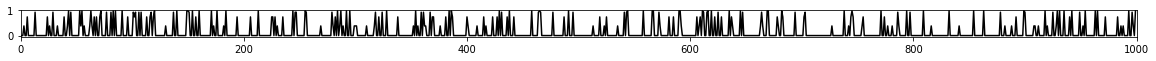

In [11]:
for n in range(5):
    plt.figure(figsize=(20, 0.5))
    plt.plot(sim.fr[n], color='k')
    plt.xlim([0, K])
    plt.show()

In [12]:
stim = np.zeros((N, K))
for n in range(N):
    locs = np.where(sim.tars == n)[0]
    stim[n, locs] = sim.I[locs]

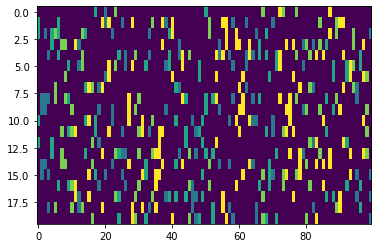

In [13]:
plt.imshow(stim[:, :100], aspect='auto', interpolation='nearest')

In [14]:
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])

In [39]:
fit_options_with_alpha = {
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 4,
    'penalty': 5e-3,
    'learn_alpha': True
}

fit_options_wo_alpha = {
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 1,
    'penalty': 1e-3,
    'learn_alpha': False
}

fit_options = [fit_options_with_alpha, fit_options_wo_alpha]

priors = {
    'alpha': 1 * np.ones(N), # 0.05
    'beta': 1e1 * np.ones(N),
    'mu': np.zeros(N),
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

models = [adaprobe.Model(sim.cell_locs, priors=priors) for _ in range(2)]

In [40]:
# model.reset()

In [41]:
learn_alpha_vec = [0, 1]
for i in range(2):
# for i in [1]:
    %time models[i].fit(sim.y, stim, fit_options=fit_options[i], method='cavi_offline_spike_and_slab_NOTS_jax')

CPU times: user 1min 1s, sys: 1min 2s, total: 2min 3s
Wall time: 7.81 s
CPU times: user 53.3 s, sys: 54.6 s, total: 1min 47s
Wall time: 6.79 s


In [42]:
bin_stimulus_matrix = stim.copy()
bin_stimulus_matrix[stim > 0] = 1

sparse_lasso = Lasso(alpha=1e-1, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

Lasso(alpha=0.1, fit_intercept=False)

In [43]:
w_est = [models[i].state['mu'] * models[i].state['alpha'] for i in range(2)]
# w_est = [models[i].state['mu'] for i in range(2)]

In [44]:
fontsize=14

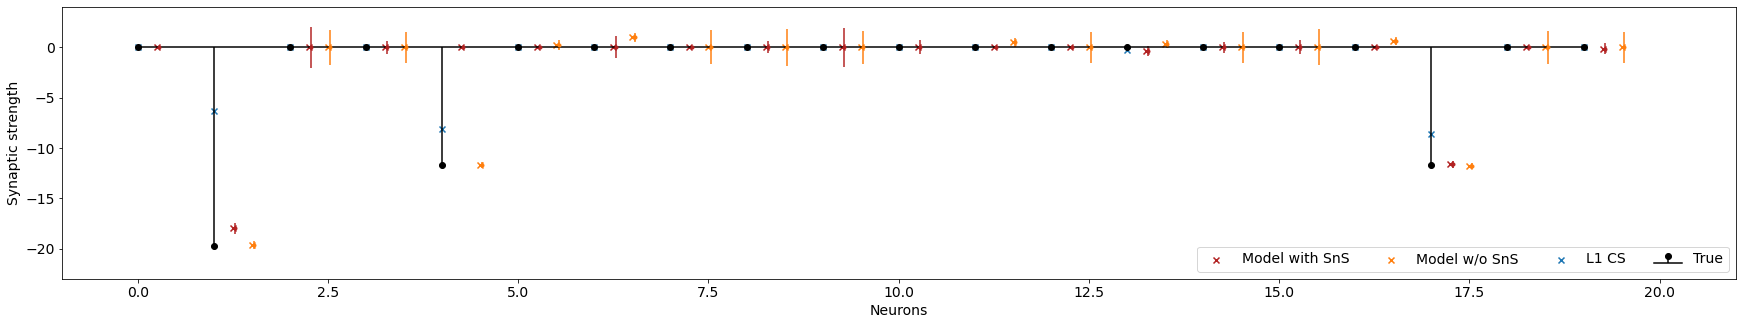

In [45]:
rng = np.arange(N)
model_offset = 0.25

cols = ['firebrick', 'C1']
labels = ['Model with SnS', 'Model w/o SnS']

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
for i in range(2):
    plt.scatter(rng + (i + 1) * model_offset, w_est[i], marker='x', color=cols[i], label=labels[i])
    plt.errorbar(rng + (i + 1) * model_offset + 0.03, w_est[i], yerr = models[i].state['beta'] * (models[i].state['alpha'] >= 0.5), fmt='.', color=cols[i])
plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')
plt.xlim([-1, N+1])
plt.legend(ncol=4, fontsize=14, loc='lower right')
plt.ylim(top=4, bottom=-23)
plt.xlabel('Neurons', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Synaptic strength', fontsize=fontsize)
# plt.savefig('figs/model_based_cs/model_vs_l1_comparison_N%i_a%.2f_sig%.2f.png'%(N, a, sigma), format='png', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

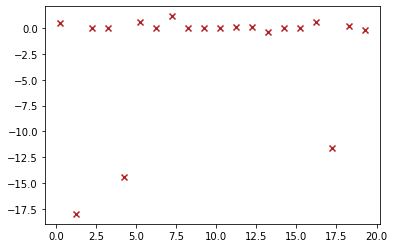

In [47]:
i = 0
plt.scatter(rng + (i + 1) * model_offset, models[i].state['mu'], marker='x', color=cols[i], label=labels[i])

In [51]:
from scipy.optimize import minimize

In [73]:
def func(x, args):
    y, A, a = args
    loss = np.sum(np.square(y - A @ x)) - np.sum(x * np.log(a) + (1 - x) * np.log(1 - a))
    return loss

In [74]:
_A = lam * mu[:, None]

In [77]:
_A.shape

(20, 1000)

In [ ]:
#  scipy.optimize.minimize(fun, x0, args=(), method='L-BFGS-B', jac=None, 
# bounds=None, tol=None, callback=None, 
# options={'disp': None, 'maxcor': 10, 'ftol': 2.220446049250313e-09, 'gtol': 1e-05, 
#'eps': 1e-08, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20, 'finite_diff_rel_step': None})

In [83]:
func(x_init, [sim.y, _A.T, 0.5])

90714.4233493272

In [105]:
args = [sim.y, _A.T, 0.05]

In [106]:
%time res = minimize(func, x_init, args=args, method='L-BFGS-B', bounds=bounds)

CPU times: user 1.61 s, sys: 297 ms, total: 1.91 s
Wall time: 1.37 s


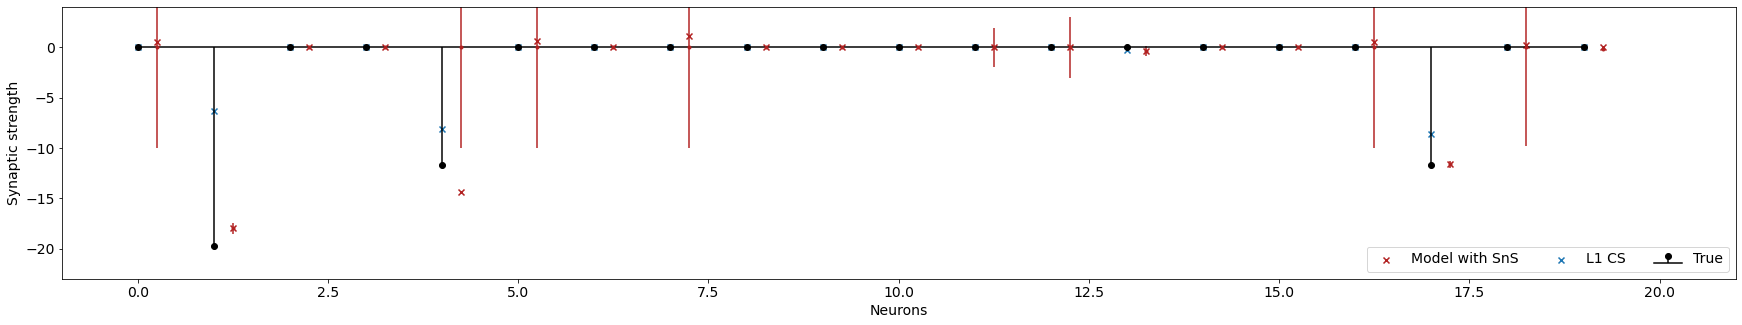

In [107]:
rng = np.arange(N)
model_offset = 0.25

cols = ['firebrick', 'C1']
labels = ['Model with SnS', 'Model w/o SnS']

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
plt.scatter(rng + (i + 1) * model_offset, models[0].state['mu'] * res.x, marker='x', color=cols[0], label=labels[0])
plt.errorbar(rng + (i + 1) * model_offset, w_est[0], yerr = models[0].state['beta'] * res.x, fmt='.', color=cols[0])
plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')
plt.xlim([-1, N+1])
plt.legend(ncol=4, fontsize=14, loc='lower right')
plt.ylim(top=4, bottom=-23)
plt.xlabel('Neurons', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('Synaptic strength', fontsize=fontsize)
# plt.savefig('figs/model_based_cs/model_vs_l1_comparison_N%i_a%.2f_sig%.2f.png'%(N, a, sigma), format='png', facecolor='white', bbox_inches='tight', dpi=200)
plt.show()

In [108]:
res.x

array([1.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.19457028, 0.30128574, 1.        , 0.        ,
       0.        , 1.        , 1.        , 0.98343897, 0.00733594])

In [ ]:
bnds = ((0.25, 0.75), (0, 2.0))

In [87]:
bounds = ([(0, 1)] * N)

In [81]:
x_init = np.random.rand(N) < 0.5

In [52]:
minimize()

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

In [59]:
lam = np.array(models[0].state['lam']).T
mu = models[0].state['mu']

(20, 1000)

In [22]:
# mu_hist = model.history['mu'].T
# alpha_hist = model.history['alpha'].T
# w_hist = mu_hist * alpha_hist

In [ ]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(np.mean(np.abs(w_hist - sim.w[:, None]), 0))
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(np.mean(np.abs(w_hist - sim.w[:, None]), 0))
# plt.ylim(bottom=0)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [ ]:
# model.reset()

In [ ]:
# model.fit(np.array(sim.y), stim_online, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

In [ ]:
xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def plot_connections(model, sim, legend=[]):    
    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)
    plt.figure(figsize=(15, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        plt.plot(xrange, post[n], color='firebrick')
        true_col = 'gray' if sim.w[n] == 0 else 'black'
        plt.plot([sim.w[n], sim.w[n]], [0, postmax], '--', color=true_col)
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.xlabel('Synaptic strength')
            plt.ylabel('Probability density')
        if n == 0 and legend is not None:
            plt.legend(legend, loc='upper left', frameon=False)
    plt.show()

plot_connections(model, sim)

In [ ]:
plt.plot(model.history['alpha'])
plt.show()

In [ ]:
print(np.round(model.state['mu'], 2))
print(np.round(sim.w, 2))

In [ ]:
def plot_spike_pred(model, sim, xlim=None):
#     spks = np.array(sim.spks).astype(float) # true simulated spikes
#     fr = np.array(sim.fr).T # true simulated firing rates
    lam = np.array(model.state['lam']).T # inferred firing rate
    spks = sim.spks
    fr = sim.fr
    print(spks.shape)
    s_pred = (lam >= 0.5).astype(float) # spike prediction
    for n in range(N):
        plt.figure(figsize=(25, 0.75))
        if sim.w[n] == 0:
            plt.plot(fr[n], color='gray') # disconnected cell
        else:
            plt.plot(fr[n], color='k') # connected cell
        plt.plot(lam[n], '--', color='r')
        plt.scatter(np.arange(len(spks[n])), spks[n], color='gray')
        plt.scatter(np.arange(s_pred[0].shape[0]), s_pred[n], 50, marker='x', color='r')
        if xlim is not None:
            plt.xlim(xlim)
        else:
            plt.xlim([0, lam.shape[-1]])
        plt.ylim([0, 1.1])
        plt.show()

In [ ]:
plot_spike_pred(model, sim)

In [ ]:
model.state['mu']

In [ ]:
alpha = model.state['alpha']
w_est = model.state['mu'] * alpha
beta = model.state['beta']

In [ ]:
bin_stimulus_matrix = stim.copy()
bin_stimulus_matrix[stim > 0] = 1

In [ ]:
sparse_lasso = Lasso(alpha=1e-1, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

In [ ]:
rng = np.arange(N)
model_offset = 0.25

plt.figure(figsize=(30, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='ko', basefmt='k-', label='True')
plt.scatter(rng + model_offset, w_est, marker='x', color='firebrick', label='Model')
plt.errorbar(rng + model_offset + 0.03, w_est, yerr= beta * (alpha >= 0.5), fmt='.', color='firebrick')
plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')
plt.xlim([-1, N+1])

plt.ylim(top=4, bottom=-23)

In [ ]:
locs = np.where(w_est < 0)[0]

In [ ]:
np.corrcoef(sim.w[locs], w_est[locs])[0, 1]

In [ ]:
np.corrcoef(sim.w, sparse_lasso.coef_)[0, 1]

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(sim.w, w_est)
plt.scatter(sim.w, sparse_lasso.coef_)
plt.xlim([-21, 1])
plt.ylim([-21, 1])
plt.xlabel('true')
plt.ylabel('lasso')
plt.show()

In [ ]:
def get_gauss_fn(mu, sig):
    def func(x):
        return 1/np.sqrt(2 * np.pi * sig**2) * np.exp(-(x - mu)**2/(2 * sig**2))
    return func

In [ ]:
phi = model.state['phi']
phi_cov = model.state['phi_cov']
phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
plow = phi - phi_sdevs
phigh = phi + phi_sdevs

phi_true = np.c_[sim.phi_0, sim.phi_1]

In [ ]:
Irng = np.arange(0, 61)

In [ ]:
ncols = 5
nrows = int(np.ceil(N/ncols))
panel_size = 2.5
plt.figure(figsize=(ncols * panel_size, nrows * panel_size))
for n in range(N):
    plt.subplot(nrows, ncols, n + 1)
    if sim.z[n]:
        true_col = 'k'
        linestyle='-'
    else:
        true_col = 'gray'
        linestyle='--'
    plt.plot(sigmoid(phi_true[n, 0] * Irng - phi_true[n, 1]), linestyle=linestyle, color=true_col)
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color='firebrick')
    plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor='firebrick', edgecolor='None', alpha=0.25)
    if n == 0:
        plt.xlabel('Power', fontsize=fontsize)
        plt.ylabel('Spike probability', fontsize=fontsize)
        
    plt.tight_layout()
plt.show()

# Jax updates

In [ ]:

def _eval_lam_update_monte_carlo(I, phi_0, phi_1):
    fn = sigmoid(phi_0 * I - phi_1)
    return jnp.log(fn/(1 - fn))

_vmap_eval_lam_update_monte_carlo = vmap(_eval_lam_update_monte_carlo, in_axes=(None, 0, 0))


In [ ]:
@jit
def update_beta(alpha, lamk, shape, rate, beta_prev):
    return 1/jnp.sqrt(shape/rate * alpha * lamk + 1/(beta_prev**2))

In [ ]:
@jit # in-place index_updates fast enough?
def update_mu(yk, mu, beta, alpha, lamk, shape, rate, mu_prev, beta_prev, mask):
    N = mu.shape[0]
    sig = shape/rate
    for n in range(N):
        index_update(mu, n, (beta[n]**2) * (sig * alpha[n] * yk * lamk[n] - sig * alpha[n] * lamk[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + mu_prev[n]/(beta_prev[n]**2)))
    return mu

In [ ]:
@jit
def update_alpha(yk, mu, beta, alpha, lamk, shape, rate, alpha_prev, mask):
    N = mu.shape[0]
    for n in range(N):
        arg = -2 * mu[n] * yk * lamk[n] + 2 * mu[n] * lamk[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + (mu[n]**2 + beta[n]**2) * lamk[n]
        index_update(alpha, n, sigmoid(jnp.log((alpha_prev[n] + EPS)/(1 - alpha_prev[n] + EPS)) - shape/(2 * rate) * arg))
    return alpha

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
plt.figure()
plt.hist(jax.random.truncated_normal(key, 0, jnp.inf, [10000]), 20)
plt.show()

In [ ]:
from jax.scipy.special import ndtr, ndtri

In [ ]:
mean = jnp.array([0.037, 2.218])
sdev = jnp.diag(posterior[1])

In [ ]:
key = jax.random.PRNGKey(0)
# key, key_next = jax.random.split(key)

In [ ]:
def get_trunc_norm_sampler(n_samples=100):
    def _sample_phi_independent_truncated_normals(key, mean, sdev):
        key, key_next = jax.random.split(key)
        u = jax.random.uniform(key, [n_samples, 1])
        return ndtri(ndtr(-mean/sdev) + u * (1 - ndtr(-mean/sdev))) * sdev + mean
    return jit(_sample_phi_independent_truncated_normals)

sample_phi_independent_truncated_normals = get_trunc_norm_sampler(200)

In [ ]:
np.mean(sample_phi_independent_truncated_normals(key, posterior[0], jnp.diag(posterior[1])), axis=0)

In [ ]:
@jit
def update_lamk_monte_carlo(yk, mu, beta, alpha, lamk, shape, rate, phi_map, phi_cov, mask, omega, tark, Ik, C, num_mc_samples=5):
    """Infer latent spike rates using Monte Carlo samples of the sigmoid coefficients.
    """
    N = mu.shape[0]
    vtark = jnp.zeros(N)
    index_update(vtark, tark, 1)
    for n in range(N):
        arg = -2 * yk * mu[n] * alpha[n] + 2 * mu[n] * alpha[n] * jnp.sum(mu[mask[n]] * alpha[mask[n]] * lamk[mask[n]]) + (mu[n]**2 + beta[n]**2) * alpha[n]
        mc_samps = _sample_phi_independent_truncated_normals(phi_map[n], phi_cov[n], num_mc_samples=num_mc_samples) # samples of phi for neuron n
        mcE = 0 # monte carlo approximation of expectation
        for indx in range(num_mc_samples):
            fn = sigmoid(mc_samps[indx, 0] * Ik * vtark[n] - mc_samps[indx, 1])
            mcE = mcE + jnp.log(fn/(1 - fn))
        mcE = mcE/num_mc_samples
        index_update(lamk, n, sigmoid(mcE - shape/(2 * rate) * arg))
    return lamk

In [ ]:
@jit
def update_sigma(yk, mu, beta, alpha, lamk, prev_shape, prev_rate):
    shape = prev_shape + 1/2
    rate = prev_rate + 1/2 * (jnp.square(yk - jnp.sum(mu * alpha * lamk)) \
        - jnp.sum(jnp.square(mu * alpha * lamk)) + jnp.sum((mu**2 + beta**2) * lamk * alpha))
    return shape, rate

In [ ]:
from jax.nn import sigmoid

In [ ]:
K = 10000
I = np.zeros(K)
I[np.random.choice([0, 1], K).astype(bool)] = 50
phi = np.array([0.03, 2])
spk_prob = sigmoid(phi[0] * I - phi[1])
y = (np.random.rand(K) < spk_prob).astype(float)
# key = 0

In [ ]:
%time (posterior, logliks), key = _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)

In [ ]:
%time _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)[1].block_until_ready()

In [ ]:
nrows = 500
ncols = 2000

@jit
def myfunc_jax():
    zero_row = jnp.zeros(ncols)
    arr = jnp.array(np.random.rand(nrows, ncols))
    for n in range(nrows):
        arr = index_update(arr, n, zero_row)
    return arr

def myfunc_np():
    zero_row = np.zeros(ncols)
    arr = np.array(np.random.rand(nrows, ncols))
    for n in range(nrows):
        arr[n] = zero_row
    return arr

In [ ]:
%time myfunc_np()

In [ ]:
%time myfunc_jax().block_until_ready()

In [ ]:
plt.plot(logliks)

In [ ]:
def _laplace_approx(y, phi_prior, phi_cov, I, key):
    """Laplace approximation to sigmoid coefficient posteriors $phi$.
    """
    newton_steps=5
    t=1e1
    backtrack_alpha=0.25
    backtrack_beta=0.5
    max_backtrack_iters=40
    
    def backtrack_cond(carry):
        it, _, lhs, rhs, _, _, _ = carry
        return jnp.logical_and(it < max_backtrack_iters, jnp.logical_or(jnp.isnan(lhs), lhs > rhs))

    def backtrack(carry):
        it, step, lhs, rhs, v, J, phi = carry
        it += 1
        step *= backtrack_beta
        lhs, rhs = get_ineq(y, phi, step, v, t, J, backtrack_alpha)
        return (it, step, lhs, rhs, v, J, phi)

    def get_ineq(y, phi, step, v, t, J, backtrack_alpha):
        return negloglik_with_barrier(y, phi + step * v, phi_prior, prior_prec, I, t), negloglik_with_barrier(y, phi, phi_prior, prior_prec, I, t) \
            + backtrack_alpha * step * J @ v

    def get_stepv(phi, t):
        f = sigmoid(phi[0] * I - phi[1])

        # grad of negative log-likelihood
        j1 = -jnp.sum(I * (y - f))
        j2 = jnp.sum(y - f)
        J = jnp.array([j1, j2]) + prior_prec @ (phi - phi_prior) - 1/(t * phi)

        # hessian of negative log-likelihood
        h11 = jnp.sum(I**2 * f * (1 - f))
        h12 = -jnp.sum(I * f * (1 - f))
        h21 = h12
        h22 = jnp.sum(f * (1 - f))
        H = jnp.array([[h11, h12], [h21, h22]]) + prior_prec + jnp.diag(1/(t * phi**2))

        H_inv = jnp.linalg.inv(H)
        v = -H_inv @ J
        return v, J, H_inv

    def newton_step(phi_carry, _):
        phi, _ = phi_carry
        v, J, cov = get_stepv(phi, t)  
        step = 1.
        lhs, rhs = get_ineq(y, phi, step, v, t, J, backtrack_alpha)
        init_carry = (0, step, lhs, rhs, v, J, phi)
        carry = while_loop(backtrack_cond, backtrack, init_carry)
        _, step, lhs, _, _, _, _ = carry
        phi += step * v
        return (phi, cov), lhs

    key, key_next = jax.random.PRNGKey(key)
    phi = jnp.array(phi_prior, copy=True)
    prior_prec = jnp.linalg.inv(phi_cov)
    phi_carry = (phi, jnp.zeros((phi.shape[0], phi.shape[0])))
    return scan(newton_step, phi_carry, jnp.arange(newton_steps)), key_next

@jit
def negloglik_with_barrier(y, phi, phi_prior, prec, I, t):
    lam = sigmoid(phi[0] * I - phi[1])
    return -jnp.sum(jnp.nan_to_num(y * jnp.log(lam) + (1 - y) * jnp.log(1 - lam))) - jnp.sum(jnp.log(phi))/t + 1/2 * (phi - phi_prior) @ prec @ (phi - phi_prior)


In [ ]:
# _jlaplace_approx = jit(_laplace_approx, static_argnums=0)
laplace_approx = jit(vmap(_laplace_approx, (0, 0, 0, 0, None))) # parallel LAs across all cells

In [ ]:
ystack = jnp.array(np.c_[y, y, y].T)

Istack = jnp.array(np.c_[I, I, I].T)

phi_prior = jnp.array([0.085, 3])
phi_prior_stack = jnp.array(np.c_[phi_prior, phi_prior, phi_prior].T)

phi_prior_cov = jnp.array([[0.05, 0], [0, 1]])
phi_prior_cov_stack = jnp.array([phi_prior_cov]*3)

In [ ]:
# _laplace_approx(0, jnp.array(y), jnp.array([0.085, 3]), jnp.array([[0.05, 0], [0, 1]]), jnp.array(I), 5)

In [ ]:
%time laplace_approx(ystack, 10*phi_prior_stack, phi_prior_cov_stack, Istack, 0)[-1].block_until_ready()